In [1]:
import csv
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from multiprocessing import Pool
import itertools

In [3]:
from datascience import *
import numpy as np
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
from IPython.display import display , Image

In [5]:
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype = int)

In [6]:
#Quick snapshot of the Network
print (nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_fb)

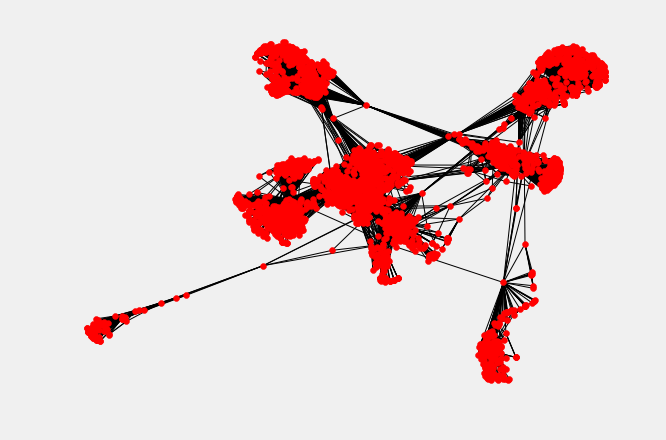

In [8]:
plt.figure(figsize=(10,7))
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)

In [9]:
#print(nx.betweenness_centrality(G_fb,normalized=True))

In [10]:
#print(G_fb.degree()) # find the number of degrees

In [11]:
#print(G_fb.neighbors(107))

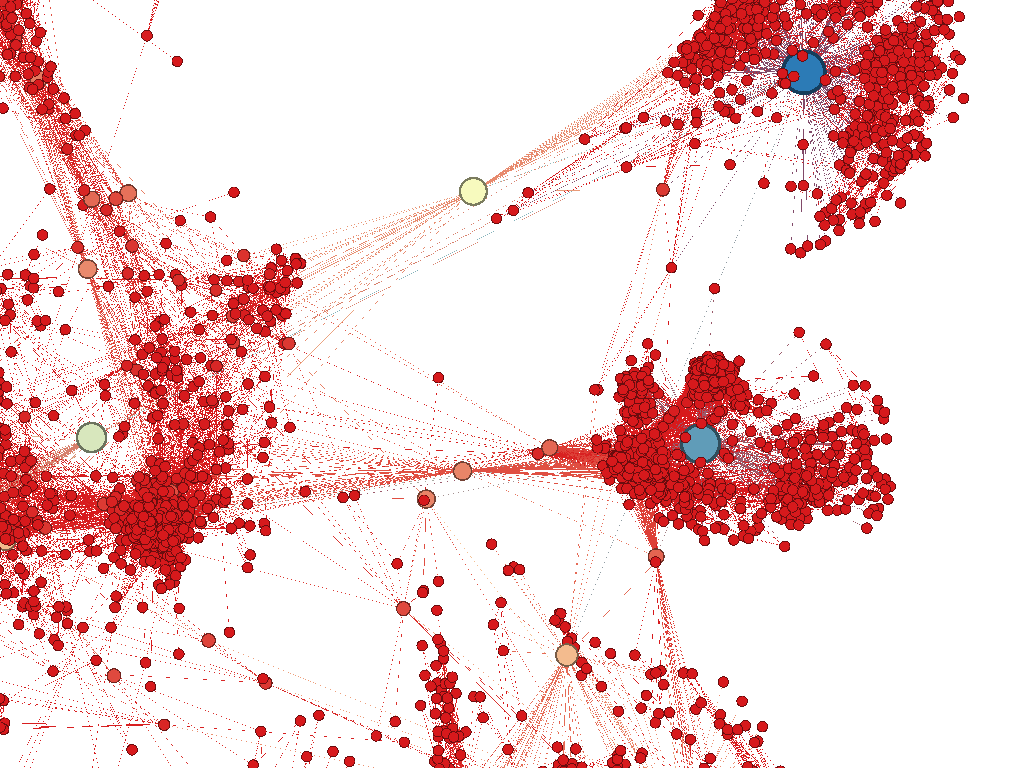

In [12]:
Image("fb_image/betweeness_among_groups.png")

# Parallel Betweenness Centrality

How do we determine who is the most "important" individual in the network. Well, that depends on the definition of "important". One way to define "importance" is the individual's betweenness centrality. The betweenness centrality is a measure of how many shortest paths pass through a particular vertex. The more shortest paths that pass through the vertex, the more central the vertex is to the network.

Because the shortest path between any pair of vertices can be determined independently of any other pair of vertices, we can take advantage of Domino's multi-core hardware to compute the betweenness centrality of each vertex in the network using a parallelized algorithm.

In [13]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [14]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [15]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [16]:
def partitions(nodes, n):  
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

# To begin the parallel computation, we initialize a Pool object with the
# number of available processors on our hardware. We then partition the
# network based on the size of the Pool object (the size is equal to the 
# number of available processors). 
def between_parallel(G, processes = None):  
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)

    #Next, we pass each processor a copy of the entire network and 
    #compute #the betweenness centrality for each vertex assigned to the 
    #processor.
    
    bet_map = p.map(btwn_pool,
                    zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))

    #Finally, we collect the betweenness centrality calculations from each 
    #pool and aggregate them together to compute the overall betweenness 
    #centrality score for each vertex in the network.

    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

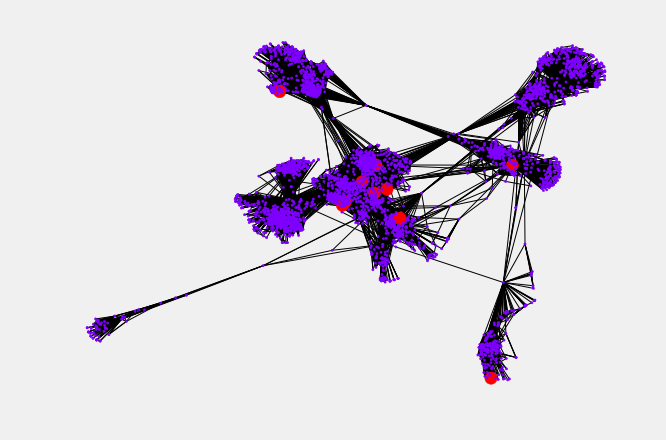

In [17]:
    
    bt = between_parallel(G_fb)
    top = 10

    max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]
    bt_values = [5]*len(G_fb.nodes())
    bt_colors = [0]*len(G_fb.nodes())
    for max_key, max_val in max_nodes:
        bt_values[max_key] = 150
        bt_colors[max_key] = 2
    
    plt.figure(figsize=(10,7))
    plt.axis("off")
    nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

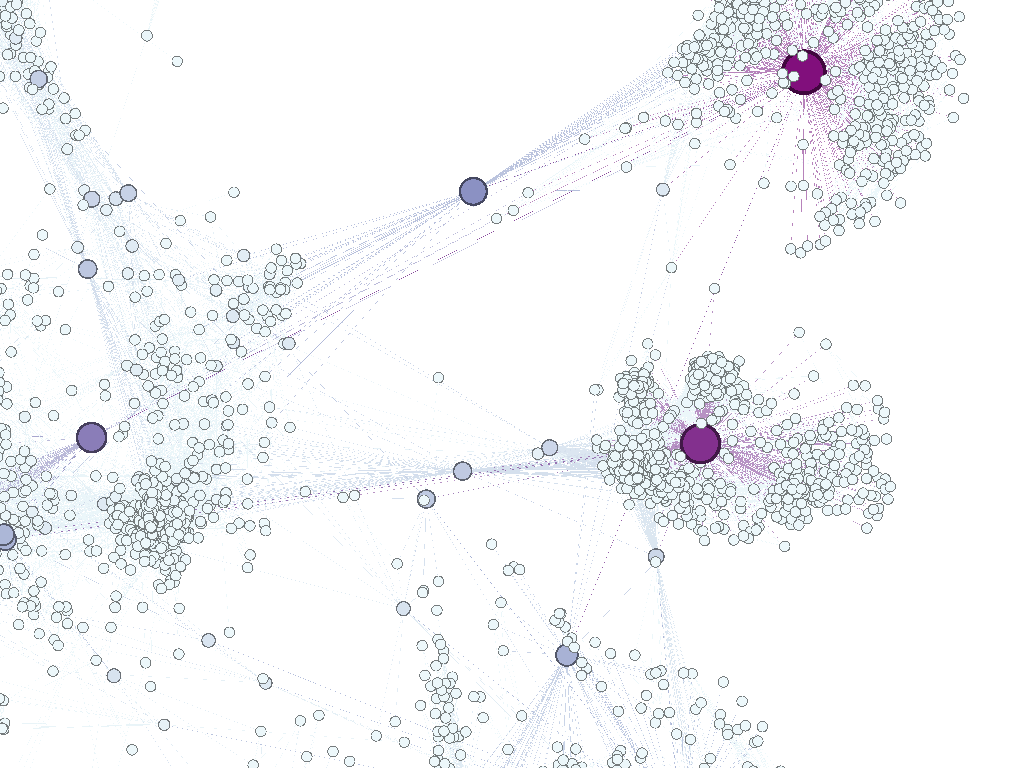

In [18]:
Image("fb_image/betweenness_communities.png")


# Community Detection

In [19]:
import comm

In [20]:
parts = comm.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]

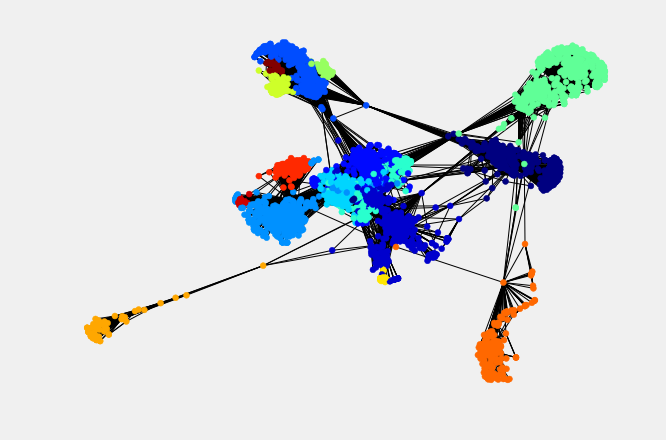

In [21]:
plt.figure(figsize=(10,7))
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

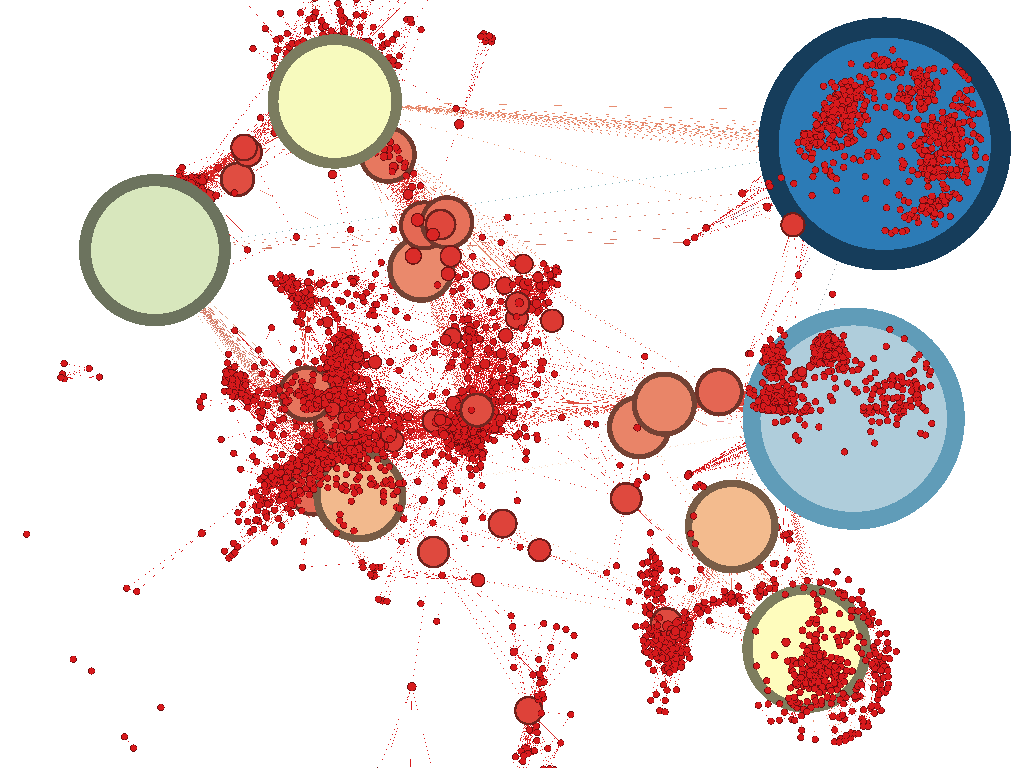

In [22]:
Image("fb_image/betweeness_centrality.png")


In [23]:
# find the order and size of our network
print(G_fb.order())
print(G_fb.size())

4039
88234


In [24]:
#find the number of triangles in the network
#print(nx.triangles(G_fb))

In [25]:
#print(nx.clustering(G_fb))

(array([ 969.,   26.,   13.,   11.,    4.,    4.,    4.,    5.,    7.,    3.]),
 array([   0. ,   11.1,   22.2,   33.3,   44.4,   55.5,   66.6,   77.7,
          88.8,   99.9,  111. ]),
 <a list of 10 Patch objects>)

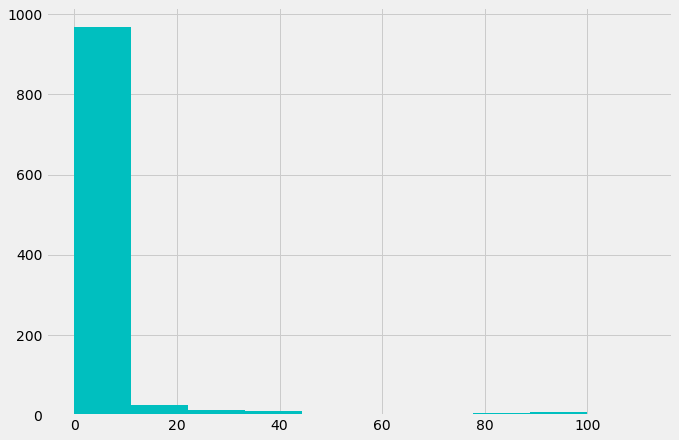

In [26]:
#draw histogram of degrees
plt.figure(figsize=(10,7))
hst = nx.degree_histogram(G_fb)
plt.hist(hst,bins=10,color='c')

In [27]:
#draw a bar chart of the betwenness centrality
#bc = nx.betweenness_centrality(G_fb)
#plt.bar(range(len(bc)),bc.values())

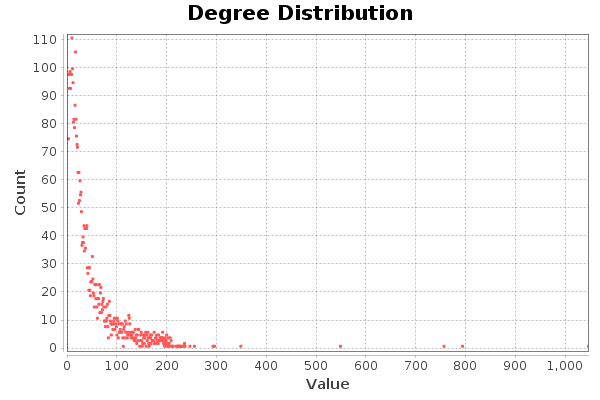

In [28]:
Image("fb_stats/degree-distribution.png")


In [29]:
nodes = []
for i in G_fb.nodes():
    if i == 'Source' or i == 'Target':
        pass
    else:
        nodes.append(i)
        
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

<a href="fb_stats/report.html">Link to the Fb rport data as generated by Gephi</a>

In [30]:
GA = nx.read_edgelist('gephi_csv.csv',delimiter=",")

# Subgraph

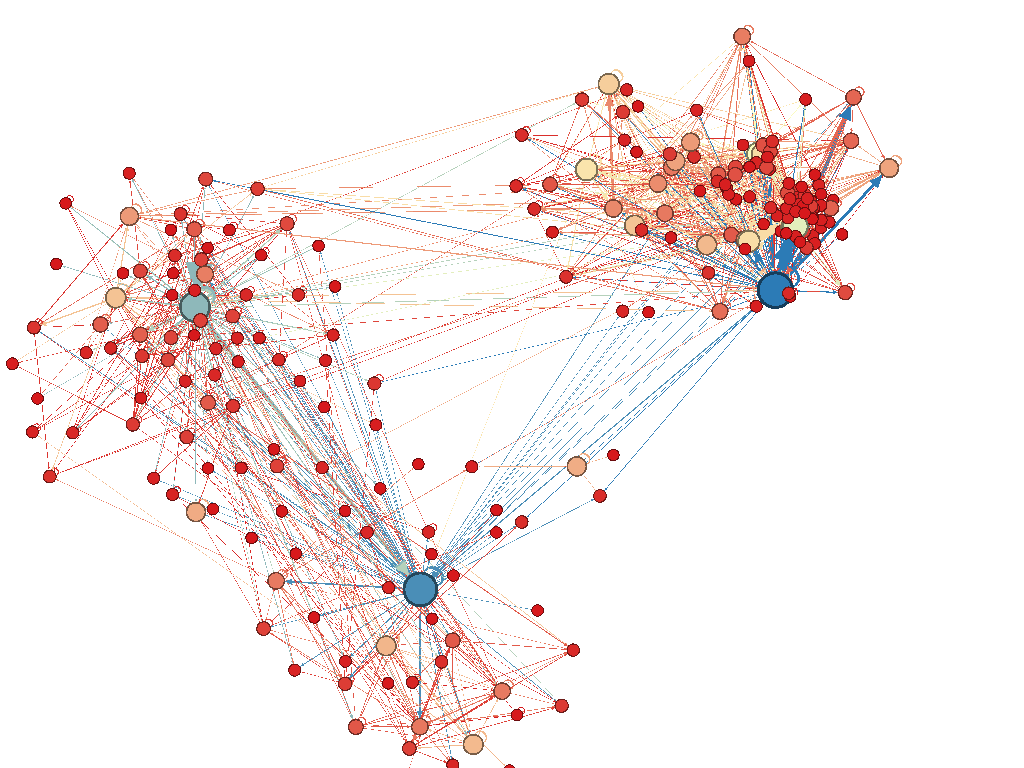

In [31]:
Image("subgraph_image/betweeness_expansion_spline.png")



In [32]:
print(nx.info(GA))

Name: 
Type: Graph
Number of nodes: 232
Number of edges: 1266
Average degree:  10.9138


In [33]:
#nx.draw_networkx(GA, with_labels=True, data='nodes.csv')

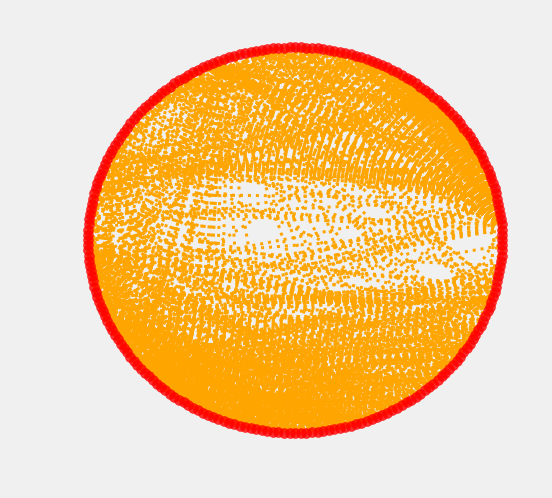

In [34]:
plt.figure(figsize=(8,8))
plt.axis('off')
layout = nx.circular_layout(GA)
nx.draw_networkx_nodes(GA, pos=layout, node_size=100, alpha=0.8) 
nx.draw_networkx_edges(GA, pos=layout, width=3, style='dotted',
                      edge_color='orange')
#nx.draw_networkx_labels(GA, pos=layout, font_size=15)
plt.show()


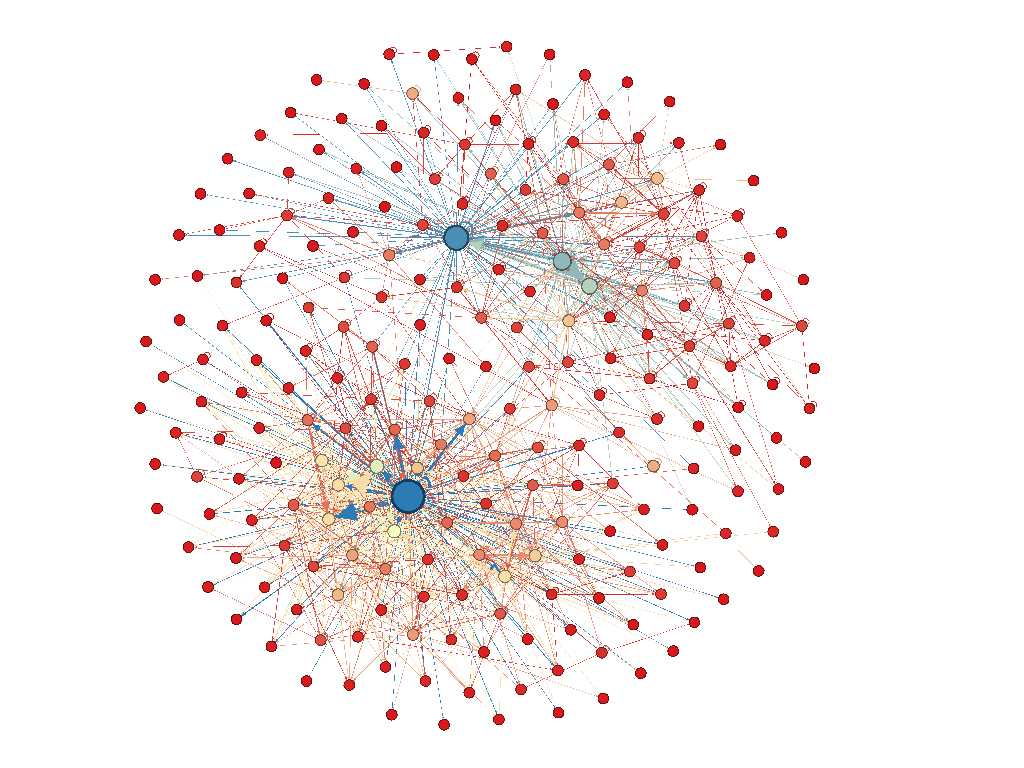

In [35]:
Image("subgraph_image/betweenness_after_spline.png")

In [36]:
# Degree of everyone
#GA.degree()
GA.degree("1")

{}

In [37]:
sorted(GA.degree().items(), key=lambda x:x[1], reverse=True)[:5]

[('215', 121), ('14', 86), ('3', 72), ('6', 58), ('240', 57)]

In [38]:
degree_node_215 = GA.degree('215')
total_nodes_minus_215 = len(GA.nodes()) - 1

In [39]:
# Degree centrality for nodeOne
degree_centrality_nodeOne = (degree_node_215 / total_nodes_minus_215)
print("Calculated degree centrality for Node_215:", degree_centrality_nodeOne)

Calculated degree centrality for Node_215: 0.5238095238095238


In [40]:
# Double check using networkx built function
print("Networkx degree centrality for Node_215:", nx.degree_centrality(GA)["215"])


Networkx degree centrality for Node_215: 0.5238095238095238


In [41]:
# degree centrality for all Nodes
degree_centrality = nx.degree_centrality(GA)
degree_centrality

{'10': 0.047619047619047616,
 '100': 0.008658008658008658,
 '103': 0.004329004329004329,
 '108': 0.017316017316017316,
 '109': 0.030303030303030304,
 '11': 0.025974025974025976,
 '115': 0.008658008658008658,
 '117': 0.025974025974025976,
 '12': 0.004329004329004329,
 '121': 0.004329004329004329,
 '124': 0.06926406926406926,
 '125': 0.008658008658008658,
 '127': 0.004329004329004329,
 '13': 0.021645021645021644,
 '137': 0.06493506493506493,
 '14': 0.3722943722943723,
 '142': 0.004329004329004329,
 '144': 0.03463203463203463,
 '145': 0.030303030303030304,
 '148': 0.012987012987012988,
 '149': 0.008658008658008658,
 '15': 0.03463203463203463,
 '153': 0.04329004329004329,
 '154': 0.05194805194805195,
 '159': 0.021645021645021644,
 '16': 0.04329004329004329,
 '161': 0.008658008658008658,
 '166': 0.012987012987012988,
 '167': 0.030303030303030304,
 '173': 0.008658008658008658,
 '18': 0.008658008658008658,
 '19': 0.008658008658008658,
 '190': 0.008658008658008658,
 '192': 0.008658008658008658

In [42]:
sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

[('215', 0.5238095238095238),
 ('14', 0.3722943722943723),
 ('3', 0.3116883116883117),
 ('6', 0.2510822510822511),
 ('240', 0.24675324675324675)]

In [43]:
nx.set_node_attributes(GA, 'degree centrality', degree_centrality)

In [44]:
GA.node['215']

{'degree centrality': 0.5238095238095238}

In [45]:
# Closeness Centrality
# Shortest path between nodeOne and other nodes in the network
node215_shortest_path = nx.shortest_path_length(GA)['215']
node215_shortest_path

{'10': 2,
 '100': 3,
 '103': 3,
 '108': 2,
 '109': 2,
 '11': 2,
 '115': 2,
 '117': 2,
 '12': 2,
 '121': 2,
 '124': 1,
 '125': 3,
 '127': 3,
 '13': 2,
 '137': 2,
 '14': 1,
 '142': 3,
 '144': 2,
 '145': 2,
 '148': 2,
 '149': 2,
 '15': 2,
 '153': 1,
 '154': 2,
 '159': 3,
 '16': 3,
 '161': 2,
 '166': 2,
 '167': 2,
 '173': 2,
 '18': 2,
 '19': 2,
 '190': 2,
 '192': 2,
 '196': 2,
 '20': 2,
 '200': 2,
 '201': 2,
 '202': 2,
 '204': 2,
 '209': 1,
 '21': 2,
 '214': 1,
 '215': 0,
 '216': 1,
 '22': 2,
 '223': 1,
 '227': 1,
 '229': 1,
 '23': 2,
 '231': 1,
 '232': 1,
 '236': 1,
 '237': 1,
 '238': 1,
 '239': 1,
 '24': 2,
 '240': 1,
 '241': 1,
 '242': 2,
 '243': 1,
 '245': 1,
 '246': 1,
 '247': 2,
 '248': 3,
 '25': 2,
 '252': 1,
 '253': 1,
 '254': 1,
 '255': 1,
 '256': 1,
 '259': 1,
 '26': 2,
 '260': 1,
 '262': 2,
 '263': 1,
 '265': 1,
 '27': 2,
 '271': 1,
 '272': 1,
 '273': 1,
 '275': 1,
 '276': 1,
 '277': 1,
 '278': 1,
 '279': 1,
 '28': 2,
 '280': 1,
 '281': 1,
 '282': 1,
 '283': 1,
 '284': 1,
 '285'

In [46]:
# Sum of the shortest paths to all other nodes in the graph
node215_sum_shortest_path = sum(node215_shortest_path.values())
node215_sum_shortest_path

# Closeness centrality for nodeOne
print("Networkx closeness centrality for node215:", nx.closeness_centrality(GA)["215"])
#  check_equal(closeness_centrality_grey, nx.closeness_centrality(GA)["grey"])

Networkx closeness centrality for node215: 0.6434540389972145


In [47]:
# degree centrality for all nodes
closeness_centrality = nx.closeness_centrality(GA)
closeness_centrality

{'10': 0.4017391304347826,
 '100': 0.29577464788732394,
 '103': 0.29020100502512564,
 '108': 0.3276595744680851,
 '109': 0.393526405451448,
 '11': 0.37993421052631576,
 '115': 0.39086294416243655,
 '117': 0.39690721649484534,
 '12': 0.3548387096774194,
 '121': 0.3285917496443812,
 '124': 0.47530864197530864,
 '125': 0.3458083832335329,
 '127': 0.3447761194029851,
 '13': 0.3768352365415987,
 '137': 0.4110320284697509,
 '14': 0.5907928388746803,
 '142': 0.2827417380660955,
 '144': 0.3696,
 '145': 0.3869346733668342,
 '148': 0.3725806451612903,
 '149': 0.3780687397708674,
 '15': 0.4003466204506066,
 '153': 0.4873417721518987,
 '154': 0.3843594009983361,
 '159': 0.35,
 '16': 0.3598130841121495,
 '161': 0.39086294416243655,
 '166': 0.39419795221843,
 '167': 0.3637795275590551,
 '173': 0.3725806451612903,
 '18': 0.39086294416243655,
 '19': 0.3725806451612903,
 '190': 0.37318255250403876,
 '192': 0.37318255250403876,
 '196': 0.3719806763285024,
 '20': 0.38564273789649417,
 '200': 0.3559322033

In [48]:
# Top 5. Percent of central nodes in the network
sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)

[('215', 0.6434540389972145),
 ('14', 0.5907928388746803),
 ('6', 0.5486935866983373),
 ('3', 0.525),
 ('240', 0.5144766146993318),
 ('252', 0.506578947368421),
 ('55', 0.5054704595185996),
 ('285', 0.4978448275862069),
 ('243', 0.49464668094218417),
 ('75', 0.4883720930232558),
 ('153', 0.4873417721518987),
 ('391', 0.48326359832635984),
 ('236', 0.48125),
 ('395', 0.4772727272727273),
 ('265', 0.4762886597938144),
 ('124', 0.47530864197530864),
 ('227', 0.47433264887063653),
 ('345', 0.47433264887063653),
 ('223', 0.4714285714285714),
 ('392', 0.4695121951219512),
 ('214', 0.463855421686747),
 ('256', 0.4601593625498008),
 ('315', 0.45742574257425744),
 ('350', 0.45652173913043476),
 ('298', 0.4556213017751479),
 ('305', 0.4556213017751479),
 ('322', 0.4442307692307692),
 ('378', 0.4425287356321839),
 ('239', 0.4416826003824092),
 ('272', 0.44083969465648853),
 ('246', 0.44),
 ('287', 0.4350282485875706),
 ('231', 0.4350282485875706),
 ('353', 0.42857142857142855),
 ('271', 0.4269870

In [49]:
# apply measurements back to Graph
nx.set_node_attributes(GA, 'closeness centrality', closeness_centrality)

In [50]:
GA.node['215']

{'closeness centrality': 0.6434540389972145,
 'degree centrality': 0.5238095238095238}

In [51]:
# average distance of nodeSeven
1 / closeness_centrality['14']

1.6926406926406927

In [52]:
# Betweeness Centrality
betweeness_centrality = nx.betweenness_centrality(GA)
betweeness_centrality

{'10': 0.0009116781468377979,
 '100': 0.0,
 '103': 0.0,
 '108': 3.1369596586987884e-05,
 '109': 0.008714040741082887,
 '11': 0.0,
 '115': 0.0,
 '117': 8.442004234430603e-05,
 '12': 0.0,
 '121': 0.0,
 '124': 0.020521237686736457,
 '125': 0.0,
 '127': 0.0,
 '13': 0.0,
 '137': 0.007479423116447584,
 '14': 0.29948017494003626,
 '142': 0.0,
 '144': 0.0021207249260824343,
 '145': 0.0001349853498578601,
 '148': 4.01693795256754e-05,
 '149': 0.0,
 '15': 2.6783038474671644e-05,
 '153': 0.003179104929307885,
 '154': 0.000991026213122957,
 '159': 0.00031365251856027744,
 '16': 0.0039778205941776576,
 '161': 0.0,
 '166': 9.358045971318284e-05,
 '167': 0.00036297279876829785,
 '173': 0.0,
 '18': 0.0,
 '19': 0.0,
 '190': 0.0,
 '192': 0.00040752682893110433,
 '196': 0.0,
 '20': 0.0,
 '200': 0.00018161502633552321,
 '201': 0.003961130745402948,
 '202': 0.0,
 '204': 0.0,
 '209': 0.0009092212762455572,
 '21': 0.0008426710326577238,
 '214': 0.0032809636096379534,
 '215': 0.3771268878407455,
 '216': 0.0,


In [53]:
# top 5
sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

[('215', 0.3771268878407455),
 ('14', 0.29948017494003626),
 ('3', 0.147282981133804),
 ('6', 0.11884059925083855),
 ('240', 0.054748769629975755)]

In [54]:
# apply measurements back to Graph
nx.set_node_attributes(GA, 'betwenness centrality', betweeness_centrality)

In [55]:
# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality_numpy(GA)
eigenvector_centrality

{'10': 0.011893027160558213,
 '100': 0.001162134096128345,
 '103': 0.0006272263060124455,
 '108': 0.002442647902615703,
 '109': 0.008037477952719592,
 '11': 0.006582002421471865,
 '115': 0.0066864593309666105,
 '117': 0.009166559926415897,
 '12': 0.0025388774833067923,
 '121': 0.001117297348955988,
 '124': 0.04584717862379846,
 '125': 0.003002224260993531,
 '127': 0.002573977177742211,
 '13': 0.005687546391528429,
 '137': 0.017185648450053048,
 '14': 0.09921260170894088,
 '142': 0.0003331631674619719,
 '144': 0.01063844220476663,
 '145': 0.010439980952818836,
 '148': 0.00525420559766595,
 '149': 0.004892289652636481,
 '15': 0.011916008324161278,
 '153': 0.028976463367789015,
 '154': 0.009647061901748348,
 '159': 0.003402388745376986,
 '16': 0.005722470759724407,
 '161': 0.006686459330966602,
 '166': 0.007803756679922595,
 '167': 0.005920283662778098,
 '173': 0.0045123645191599325,
 '18': 0.006686459330966612,
 '19': 0.004605462491438842,
 '190': 0.004623547253670934,
 '192': 0.00425351

In [56]:
max_value = max(eigenvector_centrality.items(), key=lambda x: x[1])

ec_scaled = {}
for k in eigenvector_centrality.keys():
    ec_scaled[k] = eigenvector_centrality[k] / max_value[1]
    
# Scaled by the most central character (nodeSeven)
sorted(ec_scaled.items(), key=lambda x:x[1], reverse=True)[0:5]

[('215', 1.0),
 ('240', 0.6660875057035371),
 ('252', 0.6107609821888458),
 ('239', 0.6107515445460232),
 ('246', 0.5355511781916876)]

In [57]:
# apply measurements back to Graph
nx.set_node_attributes(GA, 'Eigenvector centrality', eigenvector_centrality)

In [58]:
#print('Node', 'degree centrality')
#for g in GA:
#    print(g, GA.node[g], )

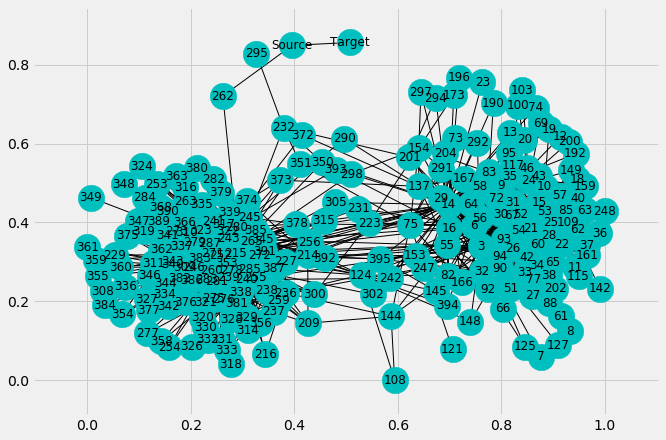

In [59]:
plt.figure(figsize=(10, 7))
dsw = nx.davis_southern_women_graph()
nx.draw_networkx(GA, node_color='c', node_size=700, with_labels=True)
#nx.draw_networkx(GA, with_labels=True, data='nodes.csv')
#print(nx.shortest_path(GA,source='215',target='14'))

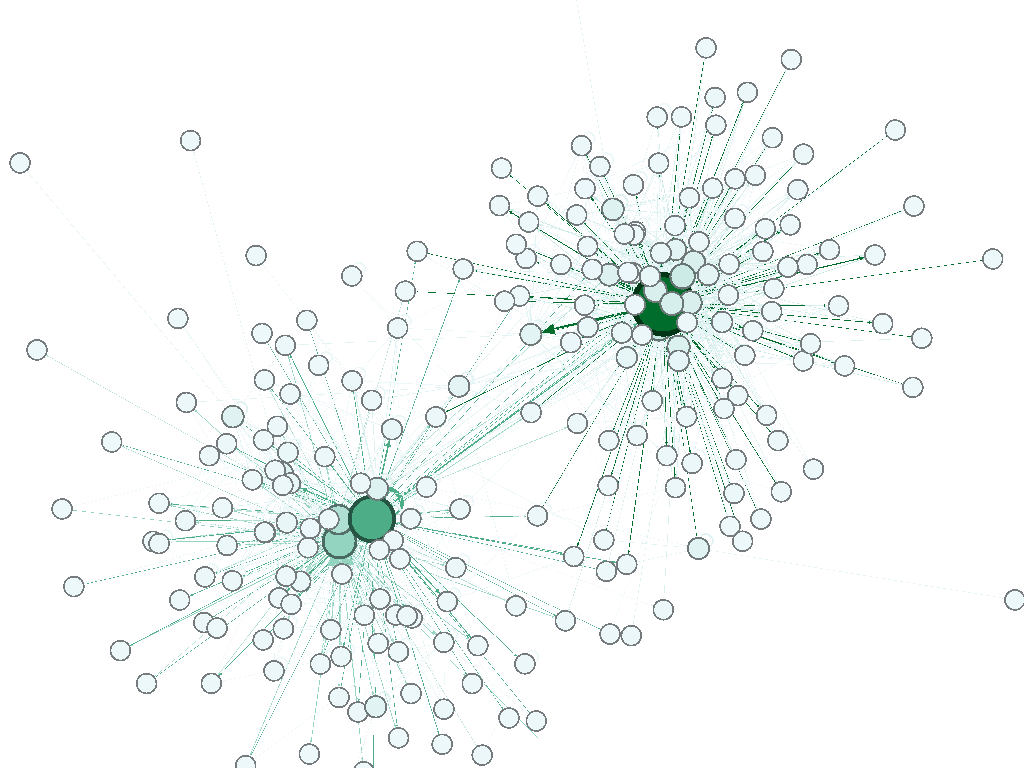

In [60]:
Image("subgraph_image/expansion_betweeness_between_communities.png")

In [61]:
print(nx.shortest_path_length(GA,source='295',target='361'))

4


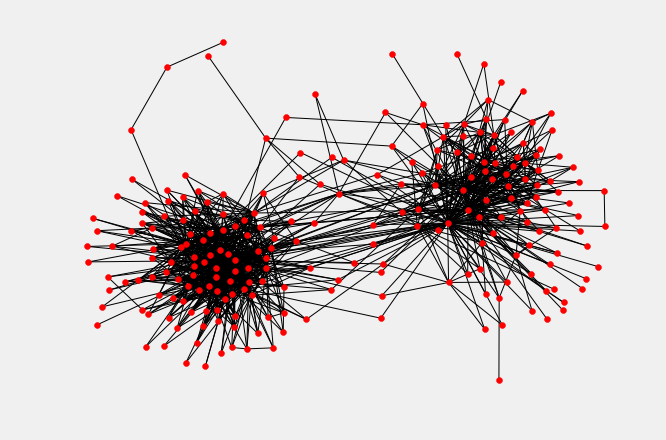

In [62]:
# create a spring-layout of fb
pos = nx.spring_layout(GA)

plt.figure(figsize=(10, 7))

plt.axis('off')

nx.draw_networkx(GA, pos=pos, with_labels=False, node_size=35)

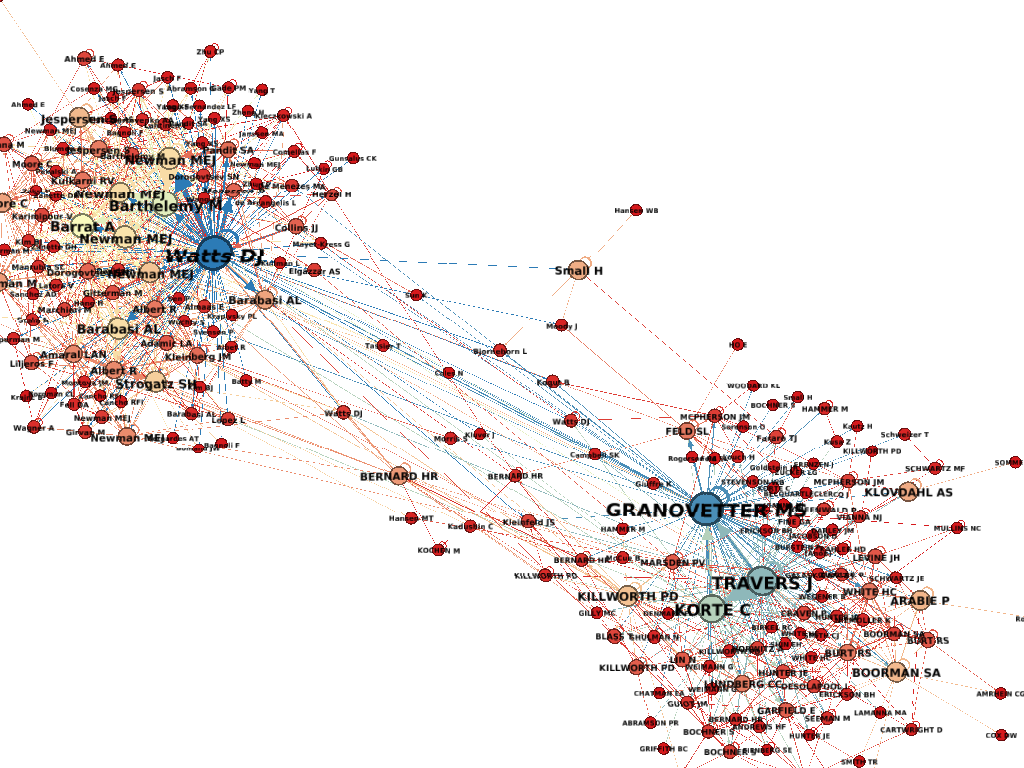

In [63]:
Image("subgraph_image/communities_modularity.png")

<a href="subgraph_stats/report.html">Generated stats for the generated subgraph</a>

In [64]:
# find the betweeeness centrality of the graph
#print(nx.betweenness_centrality(GA, normalized=True))

In [65]:
# find the order and size of our network
print(GA.order())
print(GA.size())

232
1266


In [66]:
#print(nx.clustering(GA))
# draw histogram of degrees

#plt.figure(figsize=(12,7))
#hst = nx.degree_histogram(GA)
#plt.hist(hst, bins=10, color='c')

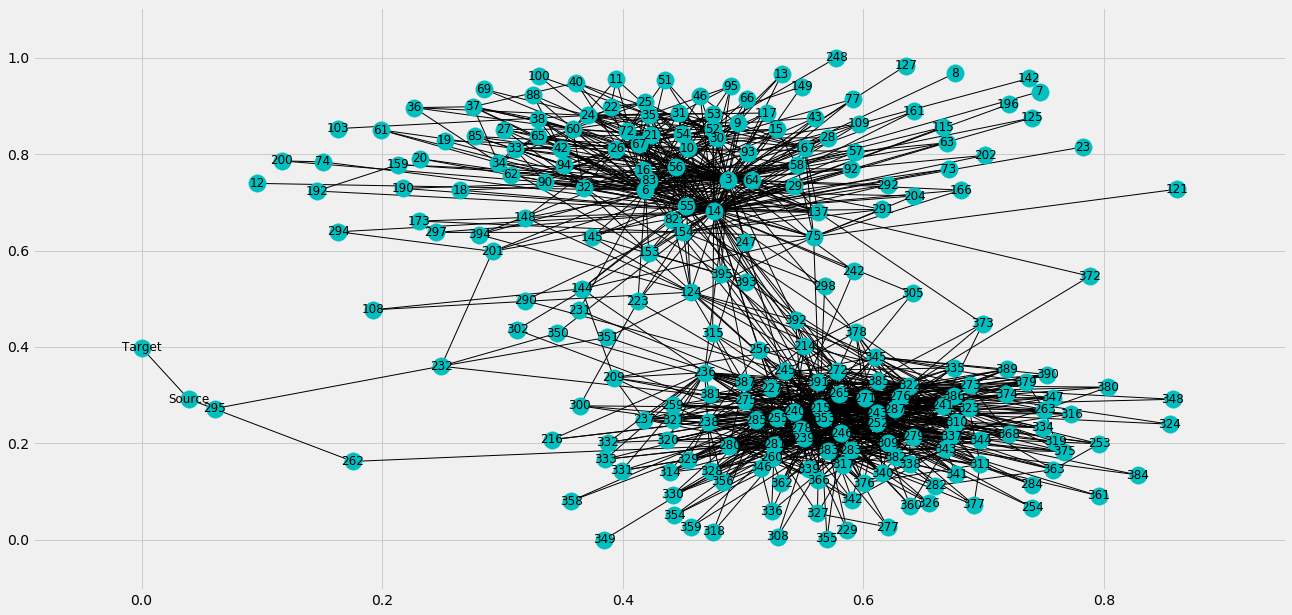

In [67]:
#barabasi-albert
plt.figure(figsize=(20,10))
nx.draw_networkx(GA,node_color='c')

In [68]:
print(nx.shortest_path_length(GA,source='349',target='74'))

3


In [69]:
GA.nodes()
print (nx.info(GA))

Name: 
Type: Graph
Number of nodes: 232
Number of edges: 1266
Average degree:  10.9138


In [70]:
nodes = []
for i in G_fb.nodes():
    if i == 'Source' or i == 'Target':
        pass
    else:
        nodes.append(i)
        
print(len(nodes))

4039


In [103]:
ten_random_choice = np.random.choice(nodes, 1000)
ten_random_choice

array([2634,  650, 2284, 1867,  867, 2521,  210,  963, 3116, 1579, 3053,
       3343, 3469, 3033, 1322, 2337,  775,  282,   79, 1457, 3822, 1282,
       2818, 2685,   82,  240, 1559, 2815, 3816,  991, 2148,  959, 1645,
        825, 3473, 1408, 2721, 2998, 1355, 3684, 1716, 2082, 3808, 2289,
       2009,  770, 1843, 1334, 1177,  558, 1550,  955, 3416, 1947,  785,
       3500, 3766, 1840, 2098, 1942,  836, 3401,  509, 3751,  361, 1469,
       3658, 3794, 1539, 2708, 3578, 3567,  508, 2123, 3322,   91, 1608,
        126, 2648, 1736, 2572, 3610, 1466, 3726, 2058, 3683, 3769, 1910,
       2000, 3753, 2981, 3372, 2593, 3188, 2768, 1968,   39,  887, 1872,
       1761, 3353,  421, 1079,  282, 2944, 3144, 1399, 3776, 1714, 4015,
       1312, 3267, 2613, 3215, 1918,  857, 1018, 1593,  375, 1250, 3630,
        868, 1826, 2696, 1351, 2120,  487, 2909, 3186, 3714, 1523, 1246,
       2309, 3754, 1554, 2906, 2035, 2084, 2355, 2230, 2809, 2897,  538,
       2082, 1522, 3300, 3930, 2682, 3418,   30, 38

In [104]:
#top_five_central = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
#top_five_central


In [105]:
bt = between_parallel(G_fb)
top = 10

max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]

In [106]:
top_five = []
for i in max_nodes:
    top_five.append(i[0])
    
print(top_five)
print('Random five',np.random.choice(top_five))

[107, 1684, 3437, 1912, 1085, 0, 698, 567, 58, 428]
Random five 3437


In [107]:

def avg_shortest_path(random_nodes ):
    listOne = []
    listTwo = []
    #servers = ['Source','Target']
    servers = [2939, 3252]
    for i in ten_random_choice:
        l = nx.shortest_path_length(G_fb,source=i,target=np.random.choice(top_five))
        listOne.append(l)
        s = nx.shortest_path_length(G_fb,source=i,target=np.random.choice(servers))
        listTwo.append(s)
    return listOne, listTwo


first, second = avg_shortest_path(ten_random_choice)
#print(first)
#print(second)

In [108]:
avg_list_one = make_array()
avg_list_two = make_array()

num_repetitions = 1000
    
for i in np.arange(num_repetitions):
    first_list, second_list = avg_shortest_path(ten_random_choice)
    central_total = sum(first_list)
    server_total = sum(second_list)
    
    central_average = central_total/len(first_list)
    server_average = server_total/len(second_list)
    
    avg_list_one = np.append(avg_list_one, central_average)
    avg_list_two = np.append(avg_list_two, server_average)



In [109]:

results = Table().with_columns(
    'avg_central_shortest_path', avg_list_one,
    'Avg_server_shortest_path', avg_list_two 
)
results

avg_central_shortest_path,Avg_server_shortest_path
2.764,3.525
2.846,3.525
2.737,3.522
2.811,3.524
2.764,3.522
2.784,3.524
2.817,3.525
2.807,3.522
2.803,3.524
2.772,3.526


In [110]:
#delay_bins = np.arange(-20, 201, 10)
#results.hist('avg_central_shortest_path', bins=60, unit="shortest path")

In [111]:

#results.hist('Avg_server_shortest_path',  bins=30, unit="shortest path")

In [112]:
#results.scatter('avg_central_shortest_path')

In [113]:
#results.scatter('Avg_server_shortest_path')

In [114]:
#results.plot('Avg_server_shortest_path')

In [115]:
#results.plot('avg_central_shortest_path')

In [116]:
#results.barh('avg_central_shortest_path')

In [117]:
np.median(results.column('avg_central_shortest_path'))

2.8039999999999998

In [118]:
np.median(results.column('Avg_server_shortest_path'))

3.524

In [119]:
medians = make_array()

for i in np.arange(5000):
    new_median = np.median(results.sample(500).column('avg_central_shortest_path'))
    medians = np.append(medians, new_median)

In [120]:
simulated_medians = Table().with_column('Sample Median', medians)
simulated_medians

Sample Median
2.803
2.806
2.804
2.803
2.805
2.8045
2.805
2.802
2.8
2.806


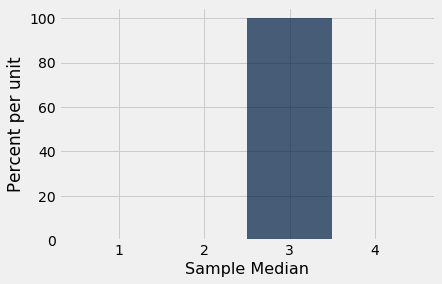

In [121]:
simulated_medians.hist(bins=np.arange(0.5, 5, 1))

In [122]:
mediansNew = make_array()

for i in np.arange(5000):
    new_median = np.median(results.sample(500).column('Avg_server_shortest_path'))
    mediansNew = np.append(mediansNew, new_median)


In [123]:
simulated_mediansNew = Table().with_column('Sample Median', mediansNew)
simulated_mediansNew

Sample Median
3.524
3.524
3.524
3.524
3.524
3.524
3.524
3.524
3.524
3.524


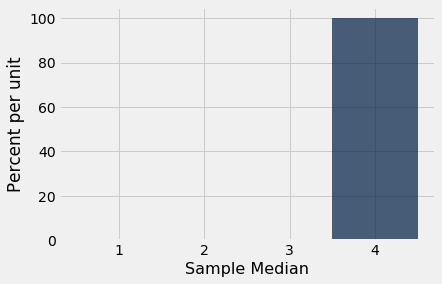

In [124]:
simulated_mediansNew.hist(bins=np.arange(0.5, 5, 1))